In [108]:
# import os
import os.path
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import pandas as pd
import fiona
import glob
import dask_geopandas
import geopandas as gpd
import time
from copy import deepcopy
from functools import reduce
import matplotlib.pyplot as plt

import aggfly
import netCDF4

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from aggfly import regions
from aggfly import dataset, regions, grid_weights
from aggfly.aggregate import TemporalAggregator, SpatialAggregator
# from aggfly.aggregate import TemporalAggregator, SpatialAggregator

ProgressBar().register()
# client = Client(n_workers=2)

project_dir = '/user/gb2884/aggfly/notebooks/giovanni_example'

In [109]:
#gdf = gpd.read_file("/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/world_geolev1_2021/world_geolev1_2021.shp")
#print(gdf.head())
#gdf.plot(color='blue', legend=True)

In [110]:
#filtered_gdf = gdf[gdf['CNTRY_NAME'] == 'United States']
#print(filtered_gdf)


In [120]:
import os
import os.path

# Years to aggregate
years = np.arange(1951,2020)
years = years[years != 1959]

georegions = regions.from_path("/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/world_geolev1_2021/world_geolev1_2021.shp",regionid='geometry')
#georegions = regions.from_path('/user/gb2884/Macro_Enviro_Dev/1_Data/world_example/IPUMSI_world_release2020/world_countries_2020.shp',regionid='OBJECTID')

# Creating GEOID column equal to GEOLEVEL1
georegions.shp["GEOID"]=georegions.shp["GEOLEVEL1"]

# Keeping only the US and filtering out empty geometry rows
#RI = georegions.shp[georegions.shp['GEOID'] == 39]
RI = georegions.shp[(georegions.shp['CNTRY_NAME'] == 'United States')]
RI = RI[RI['ADMIN_NAME'] != 'State not identified']
#RI = RI[RI['ADMIN_NAME'] != 'Great Lakes']
#RI = RI[RI['ADMIN_NAME'] != 'District of Columbia']


#georegions = georegions.sel(RI.CNTRY_CODE)
#georegions = georegions.sel(RI.GEOID)
georegions.shp = georegions.shp[georegions.shp['CNTRY_CODE'].isin(RI['CNTRY_CODE'])]
georegions.shp = georegions.shp[georegions.shp['GEOID'].isin(RI['GEOID'])]

print(georegions.shp)



print(georegions.shp.columns)

         CNTRY_NAME      ADMIN_NAME CNTRY_CODE GEOLEVEL1  BPL_CODE  \
1916  United States         Alabama        840    840001   24040.0   
1917  United States          Alaska        840    840002   24040.0   
1918  United States         Arizona        840    840004   24040.0   
1919  United States        Arkansas        840    840005   24040.0   
1920  United States      California        840    840006   24040.0   
1921  United States        Colorado        840    840008   24040.0   
1922  United States     Connecticut        840    840009   24040.0   
1923  United States        Delaware        840    840010   24040.0   
1925  United States         Florida        840    840012   24040.0   
1926  United States         Georgia        840    840013   24040.0   
1927  United States          Hawaii        840    840015   24040.0   
1928  United States           Idaho        840    840016   24040.0   
1929  United States        Illinois        840    840017   24040.0   
1930  United States 

In [121]:
# Removing empty geometry row

#print(type(ex['geometry']))


print(RI)
print(georegions.shp.shape)
georegions
print(georegions.shp)

         CNTRY_NAME      ADMIN_NAME CNTRY_CODE GEOLEVEL1  BPL_CODE  \
1916  United States         Alabama        840    840001   24040.0   
1917  United States          Alaska        840    840002   24040.0   
1918  United States         Arizona        840    840004   24040.0   
1919  United States        Arkansas        840    840005   24040.0   
1920  United States      California        840    840006   24040.0   
1921  United States        Colorado        840    840008   24040.0   
1922  United States     Connecticut        840    840009   24040.0   
1923  United States        Delaware        840    840010   24040.0   
1925  United States         Florida        840    840012   24040.0   
1926  United States         Georgia        840    840013   24040.0   
1927  United States          Hawaii        840    840015   24040.0   
1928  United States           Idaho        840    840016   24040.0   
1929  United States        Illinois        840    840017   24040.0   
1930  United States 

<Axes: >

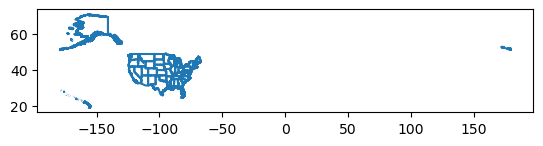

In [122]:
georegions.shp.boundary.plot()

In [123]:
def preprocess_era5l(array):
    # Function for cleaning the era5l data.
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):   
        # Reformat longitude
        array.coords['longitude'] = (array.coords['longitude'] + 180) % 360 - 180
        array = array.sortby(array.longitude)
        # Kelvin -> Celsius
        array = array - 273.15
    return array

# Open example dataset to construct weights.
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_2000_2tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)

clim.rechunk(chunks=-1)

# Calculate area and pop layer weights.
weights = grid_weights.from_objects(
    clim,
    georegions,
    wtype=None,
    simplify=0.001,
    project_dir=project_dir)


#clim.clip_data_to_georegions_extent(georegions)

print("Loading weights")
#w = weights.weights()
#nzw_ind = np.isin(clim.grid.index, w.cell_id).nonzero()
#print(w) 
#print(nzw_ind)
#print(clim.grid.index)
#print(w.cell_id)
weights.calculate_weights()

/user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-8700f314761fa0a
Creating new cache (mod-8700f314761fa0a) in /user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-8700f314761fa0a
Loading weights
[########################################] | 100% Completed | 885.58 ms
[########################################] | 100% Completed | 985.00 ms
[########################################] | 100% Completed | 1.08 s
[########################################] | 100% Completed | 1.18 s
[########################################] | 100% Completed | 1.18 s
Cache file /user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-8700f314761fa0a/c2d709b1733d84f.feather not found.
{'func': 'weights', 'raster_weights': None}
Searching for border cells...
Negative buffer
[########################################] | 100% Completed | 19.95 ss
[########################################] | 100% Completed | 20.04 s
[########################################] | 100% Completed | 2

In [124]:
print("Scheduling aggregation")
dailies = [
    TemporalAggregator('avg', 'time.date')
]
monthly = TemporalAggregator('avg', 'time.month')

Scheduling aggregation


In [125]:
out = pd.DataFrame()
#for year in years:
#    print(year)
#    start = time.time()
year = 2000

print('Loading climate data')
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_2000_2tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)
#clim.update(clim.da.persist())

clim.rechunk(chunks=-1)



print('Aggregating')
day_ds = [x.map_execute(clim, weights) for x in dailies]
month_ds = [monthly.map_execute(x, weights) for x in day_ds]

Loading climate data
Aggregating


In [126]:
clim.da
#clim.da.sel(time=clim.da.time[0]).plot()

<xarray.DataArray 't2m' (latitude: 211, longitude: 1437, time: 8616)>
dask.array<rechunk-merge, shape=(211, 1437, 8616), dtype=float32, chunksize=(211, 1437, 8616), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -179.2 -179.0 -178.8 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 71.5 71.25 71.0 70.75 ... 19.5 19.25 19.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-12-30T23:00:00

In [129]:
names = ['avg']
df = SpatialAggregator(month_ds, weights, names=names).compute()
#df_days = SpatialAggregator(month_ds, weights, names=names).compute()
    
# Clean output dataset and append
df = df.reset_index().rename(columns={'time':'month'})
df['year'] = year
#df = df[['region_id', 'year', 'month'] + names]
#df = georegions.shp[['GEOID']].merge(df, left_index=True, right_on='region_id')

#out = pd.concat([out, df])

COMPUTING
[########################################] | 100% Completed | 27.48 s
[########################################] | 100% Completed | 27.56 s
[########################################] | 100% Completed | 27.56 s
[########################################] | 100% Completed | 27.66 s
[########################################] | 100% Completed | 27.76 s
[########################################] | 100% Completed | 255.76 ms
[########################################] | 100% Completed | 303.65 ms
[########################################] | 100% Completed | 354.24 ms
[########################################] | 100% Completed | 453.84 ms
[########################################] | 100% Completed | 552.35 ms


In [130]:
print(df)
#out.reset_index().to_feather("/home3/dth2133/data/clim_data_requests/maya/temp_data_maya.feather")

     index  region_id  month        avg  year
0        0          1      1 -22.058076  2000
1        1          1      2 -13.438220  2000
2        2          1      3 -13.014210  2000
3        3          1      4  -6.490149  2000
4        4          1      5   0.135996  2000
..     ...        ...    ...        ...   ...
559    559         10      8  13.987115  2000
560    560         10      9  13.567559  2000
561    561         10     10  12.770273  2000
562    562         10     11  10.770544  2000
563    563         10     12  10.076061  2000

[564 rows x 5 columns]


In [107]:
slc = out.loc[out.year==2000].groupby('GEOLEVEL1').mean()
georegions.shp.merge(slc, right_index=True, left_on='GEOLEVEL1').plot(column='avg')

AttributeError: 'DataFrame' object has no attribute 'year'

In [51]:
print(df)
print(df_GEOID0_1)
#print(georegions.shp.columns)
#print(slc["avg"])

     GEOID  region_id  year  month        avg       date
552      0          0  2000      1   8.476435 2000-01-01
553      0          0  2000      2  11.353690 2000-02-01
554      0          0  2000      3  14.900635 2000-03-01
555      0          0  2000      4  16.036264 2000-04-01
556      0          0  2000      5  23.502539 2000-05-01
..     ...        ...   ...    ...        ...        ...
151     49         49  2000      8  21.101135 2000-08-01
152     49         49  2000      9  12.184028 2000-09-01
153     49         49  2000     10   5.758836 2000-10-01
154     49         49  2000     11  -8.140402 2000-11-01
155     49         49  2000     12  -8.997078 2000-12-01

[600 rows x 6 columns]
            GEOID  region_id  year  month        avg
date                                                
2000-01-01      0          0  2000      1   8.476435
2000-02-01      0          0  2000      2  11.353690
2000-03-01      0          0  2000      3  14.900635
2000-04-01      0          

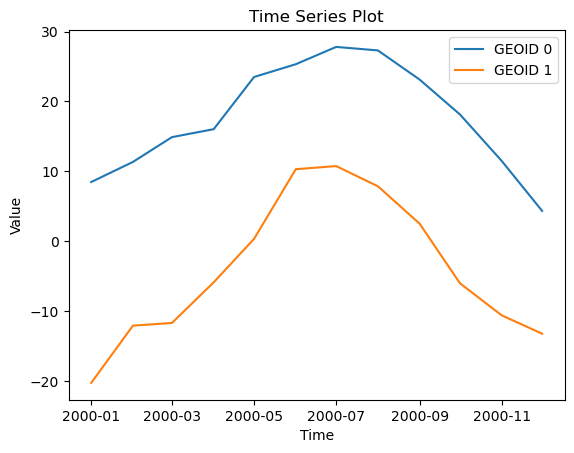

In [68]:
#df['date'] = df['month'].to_datetime(df['month'], format='%m', errors='coerce')
#df['date']=pd.to_datetime(df['month'], format='%m', errors='coerce')
#df['date']=pd.to_datetime(df['month']).dt.strftime('%Y-%m')
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2))
#df['date']=df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

df_GEOID0_1 = df[(df['GEOID'] == 0) | (df['GEOID'] == 1)]



#df_GEOID0_1.plot(column='avg', cmap='viridis', legend=True)

#df_GEOID0_1.set_index('date', inplace=True)
#plt.plot(df_GEOID0_1['date'], df_GEOID0_1['avg'])

for geoid, group in df_GEOID0_1.groupby('GEOID'):
    plt.plot(group['date'], group['avg'], label=f'GEOID {geoid}')

#plt.plot(df_GEOID0_1.index, df_GEOID0_1['avg'])

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.savefig(project_dir+"/plot.png")
plt.show()

#import matplotlib.pyplot as plt
#plt.plot(time_series_name)

In [15]:
### Maps plots

# Crop to zoom on US
# Title,...

### Time series graphs 
## Monthly for 2 states

# Merge output with shapefile
out['date'] = toplot.to_datetime(out['month'], format='%m', errors='coerce')


slc = out.loc[out.year==2000].groupby('GEOID').mean()
georegions.shp.merge(slc, right_index=True, left_on='GEOID').plot(column='avg')


toplot = georegions.shp.merge(slc, right_index=True, left_on='GEOID')
toplot = toplot.DataFrame(data)
out['date'] = toplot.to_datetime(out['month'], format='%m', errors='coerce')
toplot.plot(column='avg', cmap='viridis', legend=True, time='date')



plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.show()


# Multiple graphs aligned

# Save figure 

#

AttributeError: 'GeoDataFrame' object has no attribute 'to_datetime'